# Fitting the error-correction terms to each dataset

Back in the day (2012, 2013a, 2013b, 2015), we used to do a thing to the photometric datasets from WSERV/CASU in which we would update each ?APERMAG3ERR data point in the following way:

$$ M^2 = cE^2 + s^2 $$

with $M$ the so-called "measured error" (i.e., the realistic, actual photometric uncertainty), $E$ being the "estimated error" (the number that the pipeline spat out), $c$ a constant of proportionality, $s$ a systematic term. [Simon Hodgkin (2009)](https://ui.adsabs.harvard.edu/abs/2009MNRAS.394..675H/abstract) came up with this functional form and derived values for $c$ and $s$ as follows:

$$ c = 1.082 \pm 0.014$$

$$s = 0.021 \pm 0.001 $$

using his analysis of data in the UKIDDS large area survey (LAS) data release 3 (DR3), in which stars with repeated measurements are analyzed.

We used to just use the Hodgkin et al correction verbatim, but recently I realized that I was taking it on faith that all UKIRT/WFCAM data would be identical in terms of its photometric performance. Upon some qualitative inspection, it became clear that the actual rms of our data were lower (more precise). And, fortunately, we have enough data that it should be simple to re-do this error correction analysis ourselves.

## Re-deriving the error correction terms

Here we're going to make a series of plots and spit out some values to get the actual error performance in our cleaned data.

For these, I've used data that had either `N_?_good` or `N_?_info` for all of their `?PPERRBITS` flags.

WSERV11:
c = 0.859 ± 0.008
s = 0.0093 ± 0.0003
WSERV8:
c = 0.921 ± 0.010
s = 0.0085 ± 0.0003
WSERV7:
c = 0.919 ± 0.010
s = 0.0082 ± 0.0003
WSERV5:
c = 0.932 ± 0.033
s = 0.0101 ± 0.0011
WSERV1:
c = 0.921 ± 0.013
s = 0.0082 ± 0.0004


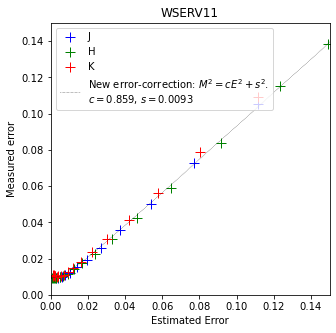

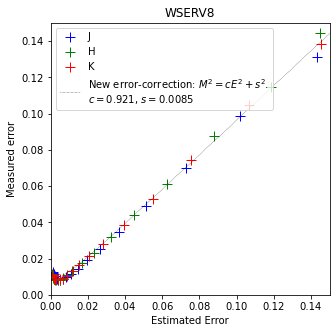

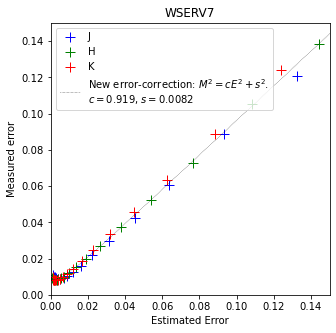

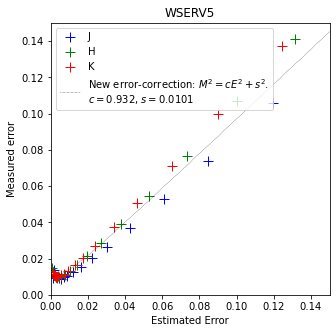

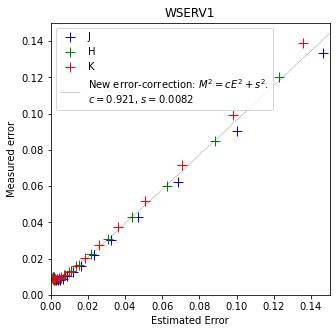

In [44]:
# In this one, we're not going to plot anything. We're just going to spit out the s, c, and uncertainty values.
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
np.warnings.filterwarnings('ignore')

def Hodgkin_error_formula(x, c, s):
    y = (c*x**2 + s**2)**0.5
    return y

%run ../rederive_error_correction.py

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

wserv_ids = [1, 5, 7, 8, 11]
for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    q2_all_indices_nonvariable = (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] < 150)
        & (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] < 150)
        & (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] < 150)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["count"]["N_J"] == ds["count"]["N_J_good"] + ds["count"]["N_J_info"])
        & (ds["count"]["N_H"] == ds["count"]["N_H_good"] + ds["count"]["N_H_info"])
        & (ds["count"]["N_K"] == ds["count"]["N_K_good"] + ds["count"]["N_K_info"])
        & (ds["median"]["PSTAR"] > 0.75)
        & (ds['variability']['J_red_chisq'] < 2)
        & (ds['variability']['H_red_chisq'] < 2)
        & (ds['variability']['K_red_chisq'] < 2)
    )
    dsn = ds[q2_all_indices_nonvariable]

    output = bin_the_median_errorbars_by_magnitude(dsn, bins=20)
    
    E_array = np.hstack([np.array(output[b]['estimated_error']) for b in ["J", "H", "K"]])
    M_array = np.hstack([np.array(output[b]['measured_error']) for b in ["J", "H", "K"]])
    
    valid = M_array < 0.15
    curve_output = curve_fit(Hodgkin_error_formula, E_array[valid], M_array[valid])
    c, s = curve_output[0]
    cov = curve_output[1]
    e_c, e_s = cov[0,0]**0.5, cov[1,1]**0.5
    
    print(f"WSERV{wserv}:")
    print(f"c = {c:.3f} ± {e_c:.3f}")
    print(f"s = {s:.4f} ± {e_s:.4f}")
    
    fig, ax = plt.subplots(1, figsize=(5,5))
    colors=['b','g','r']
    for i, b in enumerate(["J", "H", "K"]):
        ax.plot(output[b]['estimated_error'], output[b]['measured_error'], f'{colors[i]}+', ms=10, label=b)
#     plt.plot(E_array, M_array, 'k+')

    xs = np.linspace(0, 0.25, 200)
    ys = np.sqrt(c*xs**2 + s**2)
    ax.plot(xs, ys, 'k:', lw=0.5, label=f'New error-correction: $M^2 = cE^2 + s^2$.\n$c={c:.3f}$, $s={s:.4f}$')

    ax.set_ylabel("Measured error")
    ax.set_xlabel("Estimated Error")
    ax.set_title(f"WSERV{wserv}")
    ax.set_ylim(0, 0.15)
    ax.set_xlim(0, 0.15)
    ax.legend()
    



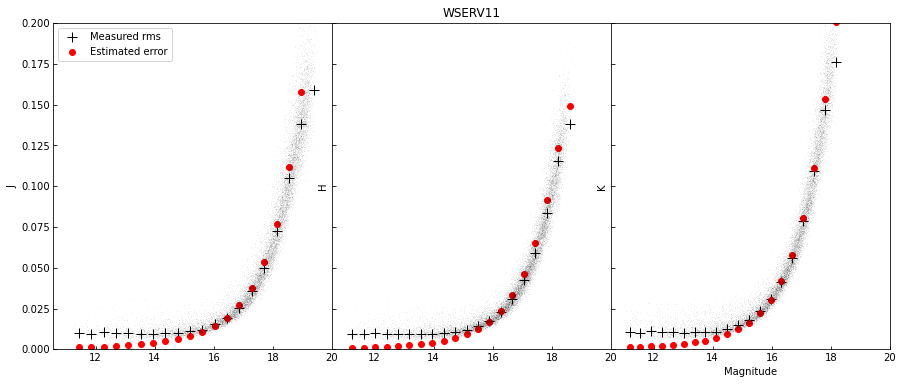

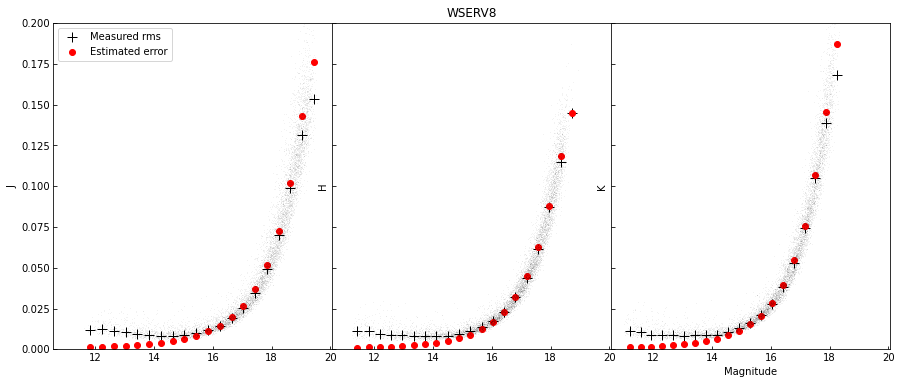

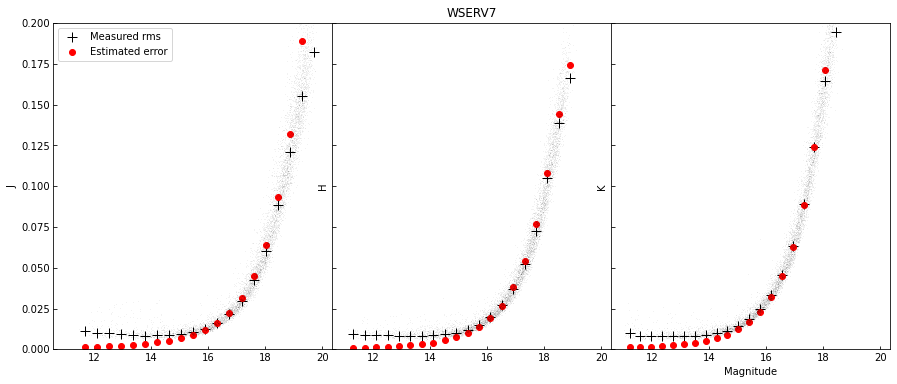

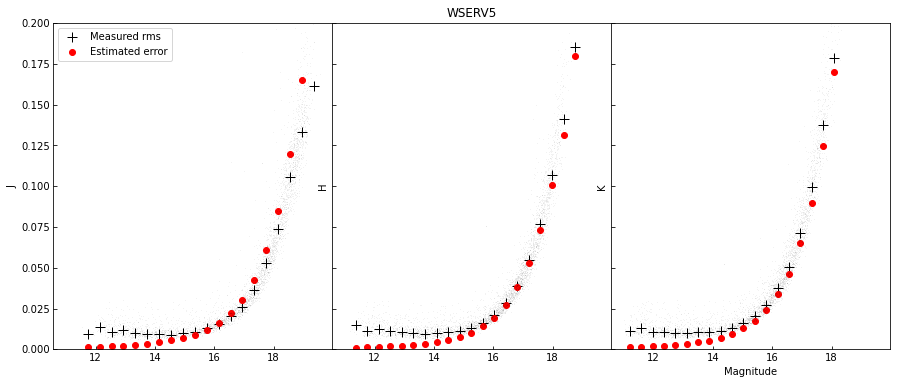

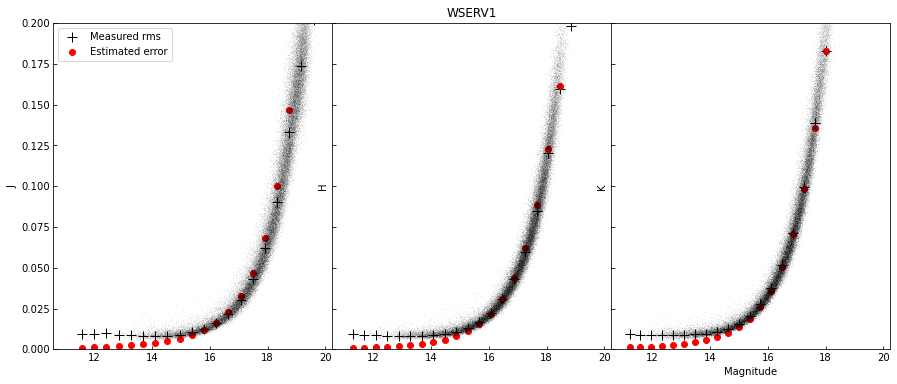

In [43]:
output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

wserv_ids = [1, 5, 7, 8, 11]
for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    q2_all_indices_nonvariable = (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] < 150)
        & (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] < 150)
        & (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] < 150)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["count"]["N_J"] == ds["count"]["N_J_good"] + ds["count"]["N_J_info"])
        & (ds["count"]["N_H"] == ds["count"]["N_H_good"] + ds["count"]["N_H_info"])
        & (ds["count"]["N_K"] == ds["count"]["N_K_good"] + ds["count"]["N_K_info"])
        & (ds["median"]["PSTAR"] > 0.75)
        & (ds['variability']['J_red_chisq'] < 2)
        & (ds['variability']['H_red_chisq'] < 2)
        & (ds['variability']['K_red_chisq'] < 2)
    )
    dsn = ds[q2_all_indices_nonvariable]

    output = bin_the_median_errorbars_by_magnitude(dsn, bins=20)
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

    for i, b in enumerate(["J", "H", "K"]):

        axes[i].plot(output[b]['mag_bin_center'], output[b]['measured_error'], 'k+', ms=10, label='Measured rms')
        axes[i].plot(output[b]['mag_bin_center'], output[b]['estimated_error'], 'ro', label='Estimated error')
        
        axes[i].plot(ds['median'][f'{b}APERMAG3'][q2_all_indices_nonvariable], ds['std'][f'{b}APERMAG3'][q2_all_indices_nonvariable], 'k,', alpha=0.05)
        
        axes[i].set_ylabel(b)
        axes[i].tick_params(direction='in')
        axes[i].set_ylim(0, 0.2)

    axes[0].legend()
    axes[1].set_title(f"WSERV{wserv}")
    axes[2].set_xlabel("Magnitude")
    plt.subplots_adjust(wspace=0)
    
    